![NN](neuron.gif)

In [34]:
!pip install git+https://github.com/jsh9/python-plot-utilities
from brian2 import *
import sympy

  Cloning https://github.com/jsh9/python-plot-utilities to c:\users\01joja\appdata\local\temp\pip-req-build-jz30u33_
  Created wheel for plot-utils: filename=plot_utils-0.6.6-py3-none-any.whl size=13278151 sha256=98060b9dc65010ebdbe14dffe1668750d53cf6b6bc364b62ae8ee8cdcad59a53
  Stored in directory: C:\Users\01joja\AppData\Local\Temp\pip-ephem-wheel-cache-bq7v9p4m\wheels\d0\99\78\05b2d3be85d4e5d1f5fec6dcb8ac2b5866bbed0a86fd1756b0
Successfully built plot-utils


Running command git clone -q https://github.com/jsh9/python-plot-utilities 'C:\Users\01joja\AppData\Local\Temp\pip-req-build-jz30u33_'


In [9]:
 
def neuron_define(input_neurons):
    input_layer=[*range(0,input_neurons)]
    inhib_layer=[*range(input_neurons,2*input_neurons)]
    left_layer=[*range(2*input_neurons,3*input_neurons-1)]
    right_layer=[*range(3*input_neurons-1,4*input_neurons-2)]
    left_neuron=[4*input_neurons-1]
    right_neuron=[4*input_neurons]
    no_excitatory_neurons= len(input_layer+left_layer+right_layer+left_neuron+right_neuron)
    no_inhibitory_neurons= len(inhib_layer)
    return input_layer, inhib_layer, left_layer, right_layer, left_neuron, right_neuron, no_excitatory_neurons, no_inhibitory_neurons

def synapse_generator(input_neurons):
    i = [] #pre synaptic
    j = [] #post synaptic
    a = neuron_define(input_neurons)
    for index in a[0]:
        #connect the layer between input layer and the inhib layer, a[1] is inhib layer.
        i.append(a[0][index])
        j.append(a[1][index])
        if index != a[0][0]:
            #connect the layer between input layer and the left layer, a[2] is left layer.
            i.append(a[0][index])
            j.append(a[2][index-1])
            #connect the layer between inhib layer and the right layer.
            i.append(a[1][index])
            j.append(a[3][index-1])
        #connect the layer between input layer and the right layer, a[3] is right layer.
        if index != a[0][-1]:
            i.append(a[0][index])
            j.append(a[3][index])
            #connect the layer between inhib layer and the left layer.
            i.append(a[1][index])
            j.append(a[2][index])
            #connect the left layer to the left neuron
            i.append(a[2][index])
            j.append(a[4][0])
            #connect the right layer to the right neuron
            i.append(a[2][index])
            j.append(a[5][0])
        
    return i,j,a[6],a[7]

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1) 
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    

In [35]:
#https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html
start_scope()

seed(11922)  # to get identical figures for repeated runs

################################################################################
# Model parameters
################################################################################
### General parameters


input_neurons = 100 ### insert no of input neurons here ###
i,j,N_e,N_i = synapse_generator(input_neurons) # Calls the function with connections

duration = 0.5*ms      # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step


### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 9.99*nS          # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -80*mV           # Inhibitory synaptic reversal potential
C_m = 198*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 10*ms          # Inhibitory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 150*pA          # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
w_i = 1.0*nS           # Inhibitory synaptic conductance
U_0 = 0.6              # Synaptic release probability at rest
Omega_d = 2.0/second   # Synaptic depression rate
Omega_f = 3.33/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic inh. conductance
'''
neurons = NeuronGroup(4*input_neurons, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'
input_layer = neurons[:input_neurons] # assigs 1/4 of the neurons to the input layer
inh_neurons = neurons[input_neurons:2*input_neurons] # assigs 1/4 of the neurons to the inhibitory layer
left_layer  = neurons[2*input_neurons:3*input_neurons-1] # assigs 1/4 -1 of the neurons to the left exitatory layer
right_layer = neurons[3*input_neurons-1:4*input_neurons-2] # assigs 1/4 -1 of the neurons to the right exitatory layer
left_neuron = neurons[4*input_neurons-2] # assigs 1 of the neurons to the final left layer
right_neuron= neurons[4*input_neurons-1] # assigs 1 of the neurons to the final right layer
### Synapses
synapses_eqs = '''
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(input_layer, inh_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S') # Connects the input layer to the inhibitory layer
exc_syn_left = Synapses(input_layer, left_layer, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S') # Connects the input layer to the left exitatory layer
exc_syn_right = Synapses(input_layer, right_layer, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S') # Connects the input layer to the right exitatory layer
inh_syn_right = Synapses(inh_neurons, right_layer, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S') # Connects the inhibitory layer to the right exitatory layer
inh_syn_left = Synapses(inh_neurons, left_layer, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S') # Connects the inhibitory layer to the left exitatory layer
final_left = Synapses(left_layer, left_neuron, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S') # Connects the left exitatory layer to the final left neuron
final_right = Synapses(right_layer, right_neuron, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S') # Connects the right exitatory layer to the final right neuron


exc_syn.connect(i=[*range(0,input_neurons)],j=[*range(0,input_neurons)])
exc_syn_left.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
exc_syn_right.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
inh_syn_right.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
inh_syn_left.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
final_left.connect(i=[*range(0,input_neurons-1)],j=0) #may need to change 0 to a 1 on J
final_right.connect(i=[*range(0,input_neurons-1)],j=0)

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1
exc_syn_left.x_S = 1
exc_syn_right.x_S = 1
inh_syn_right.x_S = 1
inh_syn_left.x_S = 1
final_left.x_S = 1
final_right.x_S = 1


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(input_layer)
inh_mon = SpikeMonitor(inh_neurons)

### We record some additional data from a single excitatory neuron
ni = 50
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(neurons, ['v', 'g_e', 'g_i'], record=ni)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[ni, :], when='after_synapses')
print('done')



run(duration, report='text')



done
Starting simulation at t=0. s for a duration of 0.5 ms
0.5 ms (100%) simulated in < 1s


ValueError: `bins` must be positive, when an integer

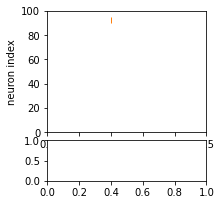

In [ ]:
input_neurons=5
i,j,N_e,N_i = synapse_generator(input_neurons)
print(N_e,N_i)

15 5


NameError: name 'S' is not defined

In [6]:
a = 5
a 
print([0,*range(0,5)])

[0, 0, 1, 2, 3, 4]


In [7]:
print(input_layer, 'exc')
print(inh_neurons, 'inh')
print(left_layer)
print(right_layer)
print(left_neuron)
print(right_neuron)

<Subgroup 'neurongroup_subgroup' of 'neurongroup' from 0 to 500> exc
<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 500 to 1000> inh
<Subgroup 'neurongroup_subgroup_2' of 'neurongroup' from 1000 to 1499>
<Subgroup 'neurongroup_subgroup_3' of 'neurongroup' from 1499 to 1998>
<Subgroup 'neurongroup_subgroup_4' of 'neurongroup' from 1998 to 1999>
<Subgroup 'neurongroup_subgroup_5' of 'neurongroup' from 1999 to 2000>
